In [9]:
# Import libraries
!pip install shap
!pip install pandas-gbq
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.cloud import bigquery 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
# Initialize connection 
project = !gcloud config get-value project
project_id = project[0]
bq = bigquery.Client(project = project_id)

In [12]:
# Read dataset in from Big Query
dataset = 'ltaylor'
table = 'Cost_02_Copy_2'
query = f"""
SELECT * 
FROM `{project_id}.{dataset}.{table}`
"""
df = bq.query(query = query).to_dataframe()
df.head()

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,invoice_date,service_description,sku_description,project_id,business_unit,cost
0,2023-10-19,Cloud Scheduler,Jobs,clgx-surveillance-prd-f609,None,0.002290
1,2023-10-19,Cloud Storage,Upload,clgx-surveillance-reg-ec2c,None,0.000000
2,2023-10-19,BigQuery,Analysis,clgx-surveillance-dr-66e6,None,0.885941
3,2023-10-19,BigQuery,Analysis,clgx-surveillance-reg-ec2c,None,0.002875
4,2023-10-19,BigQuery,Analysis,clgx-surveillance-np-reg-ccfe,None,0.742937


In [ ]:
df2 = df.copy()

# EDA/Data Cleaning

In [13]:
skus =  ['Coldline Storage US Multi-region','Standard Storage US Multi-region', 'Active Logical Storage','Analysis',
                 'Long Term Logical Storage', 'Nearline Storage US Multi-region' , 'Archive Storage US Multi-region',
         'Archive Storage US Multi-region (Early Delete)']
df['sku_description'] = [j if j in skus else 'Other' for j in df['sku_description']]
df.head()

,invoice_date,service_description,sku_description,project_id,business_unit,cost
0,2023-10-19,Cloud Scheduler,Other,clgx-surveillance-prd-f609,None,0.002290
1,2023-10-19,Cloud Storage,Other,clgx-surveillance-reg-ec2c,None,0.000000
2,2023-10-19,BigQuery,Analysis,clgx-surveillance-dr-66e6,None,0.885941
3,2023-10-19,BigQuery,Analysis,clgx-surveillance-reg-ec2c,None,0.002875
4,2023-10-19,BigQuery,Analysis,clgx-surveillance-np-reg-ccfe,None,0.742937


In [14]:
agg_df = df.groupby(['invoice_date','sku_description','project_id']).sum('cost').sort_values(['invoice_date','sku_description','project_id'])
agg_df = pd.DataFrame(agg_df).reset_index()
agg_df
agg_df['invoice_date'] = agg_df['invoice_date'].astype(str)

In [15]:
agg_df

,invoice_date,sku_description,project_id,cost
0,2021-07-05,Other,clgx-surveillance-sbx-f577,0.000000
1,2021-07-06,Other,clgx-surveillance-sbx-f577,0.000000
2,2021-07-07,Analysis,clgx-surveillance-dev-9e5e,0.696331
3,2021-07-07,Analysis,clgx-surveillance-prd-f609,0.499571
4,2021-07-07,Archive Storage US Multi-region,clgx-surveillance-dev-9e5e,0.864469
...,...,...,...,...
44145,2024-07-06,Standard Storage US Multi-region,clgx-surveillance-prd-f609,7.808019
44146,2024-07-06,Standard Storage US Multi-region,clgx-surveillance-prf-ad2a,1.181540
44147,2024-07-06,Standard Storage US Multi-region,clgx-surveillance-reg-ec2c,0.115315
44148,2024-07-06,Standard Storage US Multi-region,clgx-surveillance-sbx-f577,3.506246


In [16]:
# Top 20 sku description value counts
agg_df['sku_description'].value_counts()

sku_description
Other                                             11656
Standard Storage US Multi-region                   9095
Nearline Storage US Multi-region                   5429
Archive Storage US Multi-region                    4673
Analysis                                           3894
Long Term Logical Storage                          3451
Active Logical Storage                             3343
Coldline Storage US Multi-region                   2584
Archive Storage US Multi-region (Early Delete)       25
Name: count, dtype: int64

In [17]:
agg_df['project_id'].value_counts()

project_id
clgx-surveillance-dev-9e5e       7413
clgx-surveillance-sbx-f577       6707
clgx-surveillance-prd-f609       6560
clgx-surveillance-dr-66e6        4866
clgx-surveillance-prf-ad2a       3934
clgx-surveillance-reg-ec2c       3383
clgx-surveillance-int-4316       3335
clgx-surveillance-uat-bf45       2358
clgx-surveillance-np-reg-ccfe    2093
clgx-surveillance-sc-prd-3310    1251
clgx-surveillance-sc-sbx-750d     944
clgx-surveillance-sc-dev-28c2     471
clgx-surveillance-sc-uat-2408     471
clgx-surveillance-poc-b10b        364
Name: count, dtype: int64

In [18]:
agg_df.isna().sum()

invoice_date       0
sku_description    0
project_id         0
cost               0
dtype: int64

In [19]:
agg_df.sort_values('project_id')

,invoice_date,sku_description,project_id,cost
33387,2023-12-10,Coldline Storage US Multi-region,clgx-surveillance-dev-9e5e,5.912432
8159,2022-03-31,Nearline Storage US Multi-region,clgx-surveillance-dev-9e5e,1.310466
23088,2023-04-26,Long Term Logical Storage,clgx-surveillance-dev-9e5e,5.982468
40341,2024-04-25,Long Term Logical Storage,clgx-surveillance-dev-9e5e,14.056979
8164,2022-03-31,Other,clgx-surveillance-dev-9e5e,8.270868
...,...,...,...,...
39986,2024-04-18,Nearline Storage US Multi-region,clgx-surveillance-uat-bf45,0.003876
25763,2023-06-25,Other,clgx-surveillance-uat-bf45,0.000000
25772,2023-06-25,Standard Storage US Multi-region,clgx-surveillance-uat-bf45,0.000000
9014,2022-04-23,Standard Storage US Multi-region,clgx-surveillance-uat-bf45,0.000000


In [20]:
dates = list(agg_df['invoice_date'].unique())
skus = list(agg_df['sku_description'].unique())
skus.sort()
ids = list(agg_df['project_id'].unique())
ids.sort()

# Combos of skus and ids
vals = [[i,j] for i in skus
     for j in ids]
length = {}
for v in vals:
    x = len(agg_df[(agg_df['sku_description'] == v[0])&(agg_df['project_id'] == v[1])])
    length[str(v[0]) + ' ' +str(v[1])] = x

# Feature Engineering

In [21]:
# Create rolling median feature
date_sum = agg_df.groupby('invoice_date')['cost'].sum()
roll_med = date_sum.rolling(window=30, min_periods=1).median() 
# If cost greater than rolling median 1 else 0
agg_df['greater_than'] = [1 if (agg_df['cost'][i]) > roll_med[agg_df['invoice_date'][i]] and roll_med[agg_df['invoice_date'][i]] > 200 else 0 for i in range(len(agg_df))]

In [22]:
agg_df['invoice_date'] = pd.to_datetime(agg_df['invoice_date'])

In [23]:
# One-hot encode columns
enc_df = agg_df.copy()
enc_df = pd.get_dummies(enc_df)
enc_df.head()

,invoice_date,cost,greater_than,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Archive Storage US Multi-region,sku_description_Archive Storage US Multi-region (Early Delete),sku_description_Coldline Storage US Multi-region,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,...,project_id_clgx-surveillance-poc-b10b,project_id_clgx-surveillance-prd-f609,project_id_clgx-surveillance-prf-ad2a,project_id_clgx-surveillance-reg-ec2c,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-sc-dev-28c2,project_id_clgx-surveillance-sc-prd-3310,project_id_clgx-surveillance-sc-sbx-750d,project_id_clgx-surveillance-sc-uat-2408,project_id_clgx-surveillance-uat-bf45
0,2021-07-05,0.000000,0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2021-07-06,0.000000,0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,2021-07-07,0.696331,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2021-07-07,0.499571,0,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,2021-07-07,0.864469,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


cols =['invoice_date','cost','greater_than','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region',sku_description]
enc_df = enc_df[cols] 
enc_df.head()

In [24]:
#cols = ['invoice_date','cost','greater_than','business_unit_thvx','service_description_BigQuery','service_description_Cloud Storage','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                #'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 #'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']

In [25]:
# Keep only some columns
#cols = ['invoice_date','cost','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
               # 'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 
        #'sku_description_Active Logical Storage','sku_description_Analysis','sku_description_Long Term Logical Storage', 
        #'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']
#enc_df = enc_df[cols]

In [26]:
# Make columns binary (1,0)
for i in enc_df.drop(columns = ['cost','invoice_date'], axis = 1).columns:
    enc_df[i] = np.where(enc_df[i] == True, 1,0)
enc_df.head()

,invoice_date,cost,greater_than,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Archive Storage US Multi-region,sku_description_Archive Storage US Multi-region (Early Delete),sku_description_Coldline Storage US Multi-region,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,...,project_id_clgx-surveillance-poc-b10b,project_id_clgx-surveillance-prd-f609,project_id_clgx-surveillance-prf-ad2a,project_id_clgx-surveillance-reg-ec2c,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-sc-dev-28c2,project_id_clgx-surveillance-sc-prd-3310,project_id_clgx-surveillance-sc-sbx-750d,project_id_clgx-surveillance-sc-uat-2408,project_id_clgx-surveillance-uat-bf45
0,2021-07-05,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2021-07-06,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2021-07-07,0.696331,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-07-07,0.499571,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2021-07-07,0.864469,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Shape of df 
enc_df.shape

(44150, 26)

In [28]:
# Create features from invoice_date
#enc_df['invoice_date'] = pd.to_datetime(enc_df['invoice_date'],format='%m-%d-%Y')
#enc_df['invoice_day'] = enc_df['invoice_date'].dt.day
#enc_df['invoice_month'] = enc_df['invoice_date'].dt.month
#enc_df.head()

In [29]:
# Save invoice_dates
dates = enc_df['invoice_date']

# Drop invoice date column
enc_df.drop(labels = 'invoice_date', axis = 1, inplace = True)

# Shuffle dataset 
enc_df = enc_df.sample(frac = 1, random_state = 24)

# Initial Model Training 

In [30]:
# Train model with no hyperparameter tuning for baseline, output values. Negtive scores = anomaly, print confidence scores
model = IsolationForest(random_state = 24)
pred = model.fit_predict(enc_df)
prob_scores = abs(model.score_samples(enc_df))

In [31]:
# Create df copy to hold predictions and results
df_pred = enc_df.copy()
df_pred['invoice_date'] = dates
df_pred['label'] = pred
df_pred['prob_score'] = prob_scores

In [32]:
# Percent of data points detected as anomalies
df_pred['label'].value_counts(normalize = True)

label
 1    0.990283
-1    0.009717
Name: proportion, dtype: float64

In [33]:
# Max and average confidence score
anomalies = df_pred[df_pred['label'] == -1]

print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.5190454817383391
Max Confidence Score:  0.5311934394200728


In [34]:
len(anomalies)

429

### Overall the model seems to be misclassifying normal points as anomalous. Around 23% of data points were classified as anomalous. 
### When looking at probability scores the average value for predicted anomalies was around 0.55. This means that confidence in labels was low. Results indicate the need for hyper parameter tuning especially of contamination.

In [35]:
# Plot feature importance of first high confidence prediction using SHAP
#high_conf_2 = high_conf.drop(labels = ['invoice_date','label','prob_score'], axis = 1)
#explainer = shap.TreeExplainer(model,high_conf_2)
#shap_values = explainer(high_conf_2)
#shap.plots.waterfall(shap_values[0], max_display=16)

In [36]:
# Plot another prediction
#shap.plots.waterfall(shap_values[4], max_display=16)

In [37]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train)

In [38]:
# Overall plot
#explainer = shap.TreeExplainer(model,X_train)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train,plot_type = bar)

# Hyperparameter Tuning

# Borrowing some code from:
# https://campus.datacamp.com/courses/anomaly-detection-in-python/isolation-forests-with-pyod?ex=9

# Instantiate and train model using defined hyperparameters, return data classified as inliers 
def eval_IF(c,n_est,max_samp,max_feat,data):
    IF = IsolationForest(contamination = c, n_estimators = n_est, 
        max_samples = max_samp, max_features = max_feat,random_state = 24)
    labels = IF.fit_predict(data)
    df_res = data.copy()
    df_res['labels'] = labels
    return df_res[df_res['labels'] == 1]

# Create and train linear regression using clasisfied inliers, return RMSE
def eval_reg(data):
    X = data.drop(labels = 'cost', axis = 1)
    y = data['cost']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)
    line_reg = LinearRegression()
    #y_pred = line_reg.predict(X_test)
    cv = cross_val_score(line_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=4)
    #RMSE = mean_squared_error(y_test,y_pred, squared = False)
    return cv.mean()

In [39]:
# Hyperparameters to chose from 
#contamination = [0.01,0.05]
#n_estimators = [100,150,200]
#max_samples = [0.6,0.8]
#max_features =  [0.6,0.8]

# All different permutations of values
#param_values = [[i,j,k,l] for i in contamination
     #for j in n_estimators
     #for k in max_samples
     #for l in max_features]

#print('Number of Unique Permutations: ', len(param_values))

In [40]:
# Grid search for best hyperparameters
enc_df2 = enc_df.copy()
#scores = dict()
#for i in param_values:
        #inlier_data = eval_IF(c = i[0], n_est = i[1], max_samp = i[2], max_feat = i[3],data = enc_df2)
        #rmse = eval_reg(data = inlier_data)
        # Append scores to dictionary
       # scores[str(i)] = rmse
        

In [41]:
# Best hyperparameters
#min_error = max(scores, key=scores.get)
#print(min_error,abs(scores[min_error]))

In [42]:
# Train model with best hyperparameters
tune_model = IsolationForest(contamination = 0.0005,n_estimators = 150,max_samples = 0.6, max_features = 0.6,random_state = 24)
labels_2 = tune_model.fit_predict(enc_df2)
prob_scores = abs(tune_model.score_samples(enc_df2))

In [43]:
# Percentage of points classified as anomalous
df_res = enc_df2.copy()
df_res['label'] = labels_2
df_res['label'].value_counts(normalize = True)

label
 1    0.999479
-1    0.000521
Name: proportion, dtype: float64

In [44]:
df_res['label'].value_counts()

label
 1    44127
-1       23
Name: count, dtype: int64

In [45]:
# Average and max confidence score
df_res['prob_score'] = prob_scores
df_res['invoice_date'] = dates
df_res = df_res.sort_values('invoice_date')
anomalies = df_res[df_res['label'] == -1]
print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.6466715700574721
Max Confidence Score:  0.7450189033598742


In [46]:
anomalies.reset_index(inplace = True, drop = True)

In [47]:
anomalies.sort_values('invoice_date')

,cost,greater_than,sku_description_Active Logical Storage,sku_description_Analysis,sku_description_Archive Storage US Multi-region,sku_description_Archive Storage US Multi-region (Early Delete),sku_description_Coldline Storage US Multi-region,sku_description_Long Term Logical Storage,sku_description_Nearline Storage US Multi-region,sku_description_Other,...,project_id_clgx-surveillance-reg-ec2c,project_id_clgx-surveillance-sbx-f577,project_id_clgx-surveillance-sc-dev-28c2,project_id_clgx-surveillance-sc-prd-3310,project_id_clgx-surveillance-sc-sbx-750d,project_id_clgx-surveillance-sc-uat-2408,project_id_clgx-surveillance-uat-bf45,label,prob_score,invoice_date
0,761.585431,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,-1,0.590414,2021-07-12
1,3940.917973,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,-1,0.681523,2021-07-13
2,901.679375,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,-1,0.587812,2021-07-14
3,2500.082166,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-1,0.705263,2021-08-17
4,1171.061028,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,-1,0.628103,2021-10-06
5,22.158239,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-1,0.568263,2021-11-19
6,13494.209137,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-1,0.745019,2021-11-24
7,1882.409771,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-1,0.679271,2021-11-29
8,1745.549130,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,-1,0.667057,2021-11-30
9,2298.741823,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-1,0.701459,2021-12-15


In [48]:
anomalies.iloc[20]

cost                                                                              0.0
greater_than                                                                        0
sku_description_Active Logical Storage                                              0
sku_description_Analysis                                                            0
sku_description_Archive Storage US Multi-region                                     0
sku_description_Archive Storage US Multi-region (Early Delete)                      1
sku_description_Coldline Storage US Multi-region                                    0
sku_description_Long Term Logical Storage                                           0
sku_description_Nearline Storage US Multi-region                                    0
sku_description_Other                                                               0
sku_description_Standard Storage US Multi-region                                    0
project_id_clgx-surveillance-dev-9e5e                 

In [49]:
explainer = shap.TreeExplainer(tune_model)
shap_values = explainer.shap_values(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1)) 
shap_obj = explainer(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1))

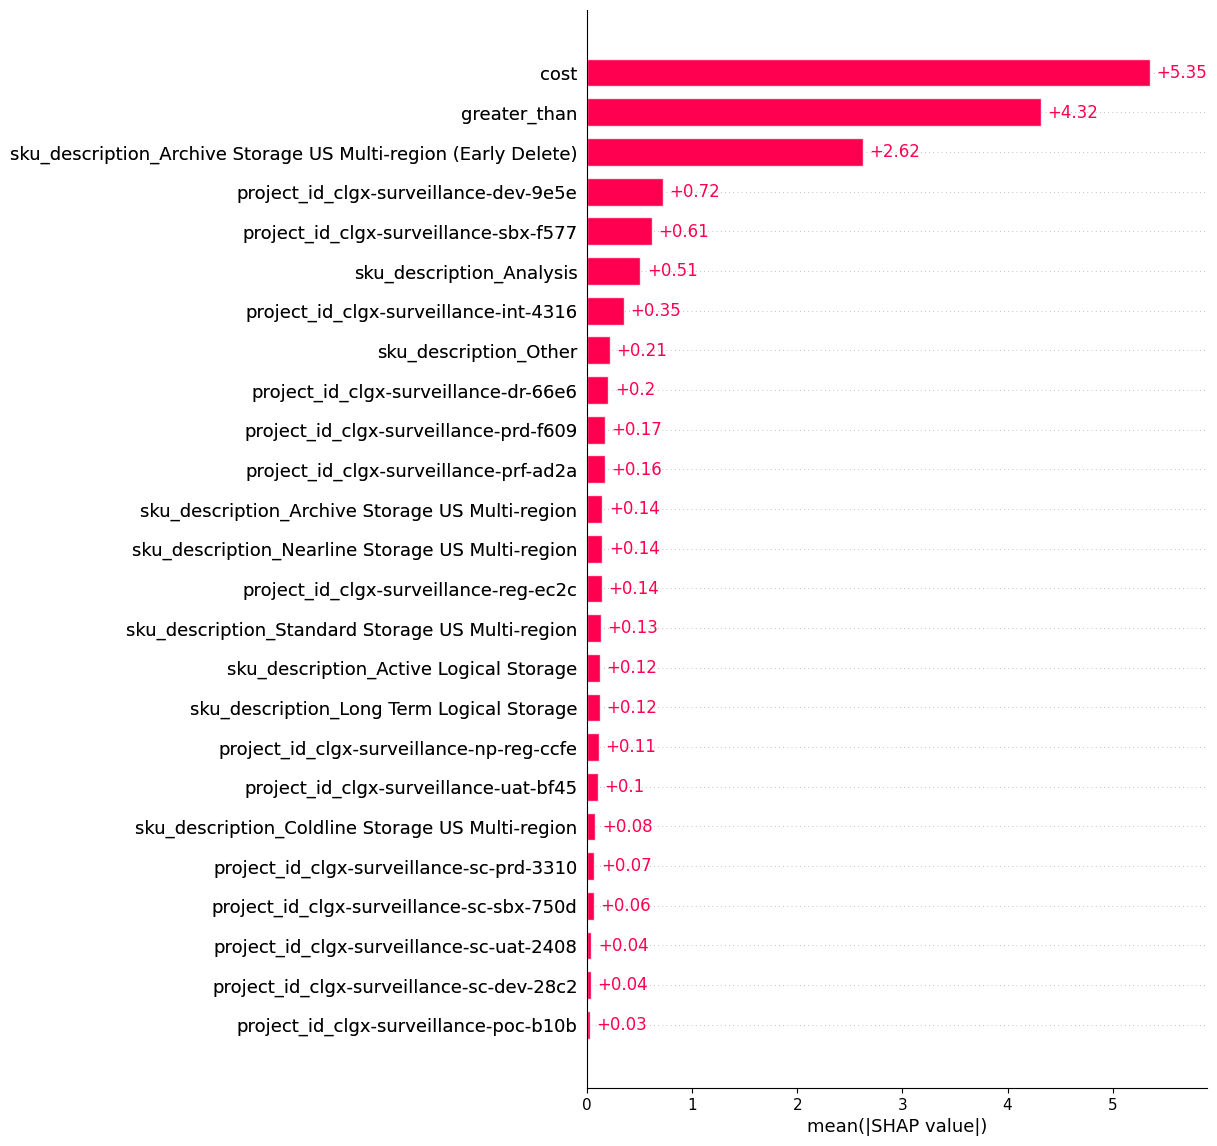

In [50]:
shap.plots.bar(shap_obj,max_display = 26)                    

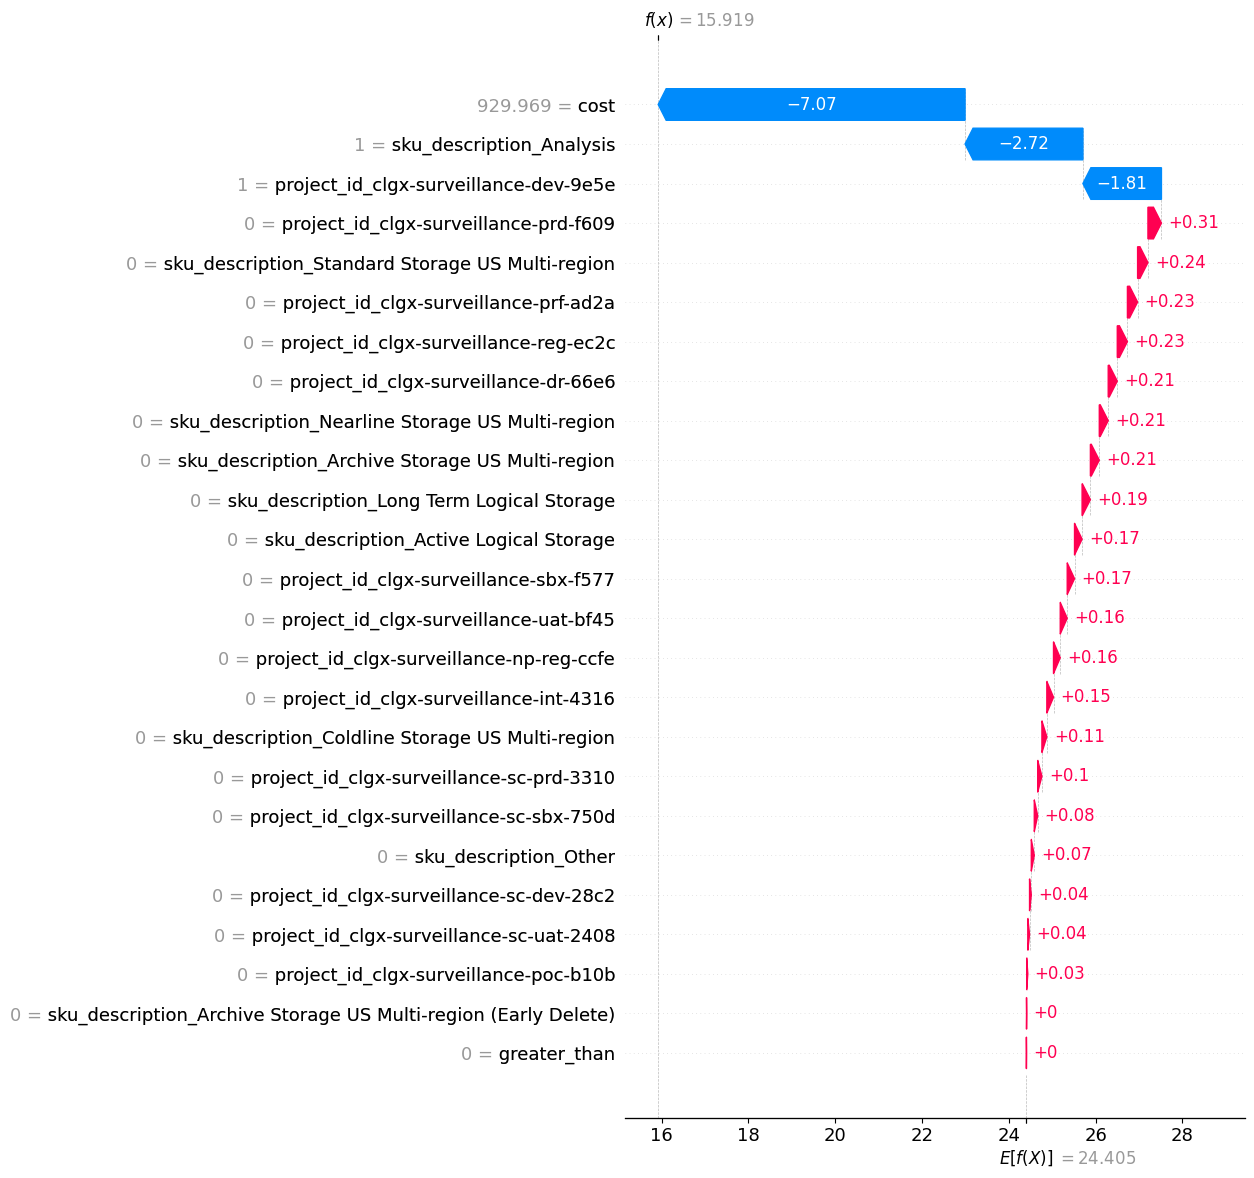

In [51]:
shap.waterfall_plot(shap_obj[22],max_display = 25)

In [52]:
### Test model on only high importance variables

In [53]:
#cols = ['invoice_date','cost','greater_than','business_unit_thvx','service_description_BigQuery','service_description_Cloud Storage','project_id_clgx-surveillance-sbx-f577','project_id_clgx-surveillance-dr-66e6','project_id_clgx-surveillance-int-4316',
                #'sku_description_Coldline Storage US Multi-region','sku_description_Standard Storage US Multi-region', 'sku_description_Active Logical Storage','sku_description_Analysis',
                 #'sku_description_Long Term Logical Storage', 'sku_description_Nearline Storage US Multi-region' , 'sku_description_Archive Storage US Multi-region']

In [55]:
enc_df3 = enc_df2[['cost','greater_than', 'sku_description_Analysis', 'sku_description_Other','sku_description_Archive Storage US Multi-region (Early Delete)']]
tune_model2 = IsolationForest(contamination = 0.0005,n_estimators = 150,max_samples = 0.8, 
                             max_features = 0.8,random_state = 24)
labels_3 = tune_model2.fit_predict(enc_df3)
prob_scores3 = abs(tune_model2.score_samples(enc_df3))

In [56]:
# Percentage of points classified as anomalous
df_res2 = enc_df3.copy()
df_res2['label'] = labels_3
df_res2['label'].value_counts(normalize = True)

label
 1    0.999479
-1    0.000521
Name: proportion, dtype: float64

In [57]:
# Average and max confidence score
df_res2['prob_score'] = prob_scores3
df_res2['invoice_date'] = dates
df_res2 = df_res2.sort_values('invoice_date')
anomalies = df_res2[df_res2['label'] == -1].reset_index(drop = True)
print('Average Confidence Score: ',anomalies['prob_score'].mean())
print('Max Confidence Score: ',max(anomalies['prob_score']))

Average Confidence Score:  0.7919577539069138
Max Confidence Score:  0.899020324057588


In [60]:
df['invoice_date'] = df['invoice_date'].astype(str)

In [67]:
df[(df['invoice_date'] == '2021-11-30') & (df['sku_description'] == 'Other')].sort_values('cost',ascending = False)

,invoice_date,service_description,sku_description,project_id,business_unit,cost
56072,2021-11-30,Cloud Storage,Other,clgx-surveillance-dev-9e5e,None,796.588335
56176,2021-11-30,Cloud Functions,Other,clgx-surveillance-dev-9e5e,foundation,778.330776
56013,2021-11-30,BigQuery,Other,clgx-surveillance-sbx-f577,None,190.000472
56181,2021-11-30,Cloud Functions,Other,clgx-surveillance-dev-9e5e,foundation,162.152120
56019,2021-11-30,BigQuery,Other,clgx-surveillance-sbx-f577,None,124.688548
...,...,...,...,...,...,...
56108,2021-11-30,Compute Engine,Other,clgx-surveillance-sbx-f577,None,0.000000
56107,2021-11-30,Compute Engine,Other,clgx-surveillance-sbx-f577,None,0.000000
56106,2021-11-30,Compute Engine,Other,clgx-surveillance-sbx-f577,None,0.000000
56105,2021-11-30,Compute Engine,Other,clgx-surveillance-sbx-f577,None,0.000000


In [58]:
anomalies

,cost,greater_than,sku_description_Analysis,sku_description_Other,sku_description_Archive Storage US Multi-region (Early Delete),label,prob_score,invoice_date
0,761.585431,1,0,1,0,-1,0.759626,2021-07-12
1,3940.917973,1,0,1,0,-1,0.860202,2021-07-13
2,901.679375,1,0,1,0,-1,0.735353,2021-07-14
3,2500.082166,1,0,0,1,-1,0.835174,2021-08-17
4,1171.061028,1,0,1,0,-1,0.795155,2021-10-06
5,13494.209137,1,0,0,1,-1,0.886213,2021-11-24
6,1882.409771,1,0,0,1,-1,0.787255,2021-11-29
7,1745.549130,1,0,1,0,-1,0.826659,2021-11-30
8,2298.741823,1,0,0,1,-1,0.827148,2021-12-15
9,816.972514,1,0,1,0,-1,0.741450,2021-12-19


In [68]:
explainer = shap.TreeExplainer(tune_model2)
shap_values = explainer.shap_values(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1)) 
shap_obj = explainer(anomalies.drop(labels = ['label','prob_score','invoice_date'],axis = 1))

In [1]:
shap.plots.bar(shap_obj,max_display = 17)  

NameError: name 'shap' is not defined

In [ ]:
shap.waterfall_plot(shap_obj[13],max_display = 17)

In [ ]:
shap.waterfall_plot(shap_obj[20],max_display = 17)

In [ ]:
shap.waterfall_plot(shap_obj[17],max_display = 17)

In [ ]:
shap.waterfall_plot(shap_obj[18],max_display = 17)

In [ ]:
df_res2.head()

In [ ]:
vis_df_agg = agg_df.copy()
vis_df_agg['prob_score'] = df_res2['prob_score']
vis_df_agg['label'] = df_res2['label']

In [ ]:
vis_df_agg.head()

In [ ]:
vis_df_agg[vis_df_agg['label'] == -1]

In [ ]:
# Upload to BQ
vis_df_agg.to_gbq('ltaylor.vis_agg', 
                 project_id, 
                 chunksize=None, 
                 if_exists='replace')